In [29]:
import pandas as pd

In [30]:
def find_match(row):
    string = 'facebook.com'
    if string in row['http_hostname:131']:
        return row['http_hostname:131']
    elif string in row['fqdn:127']:
        return row['fqdn:127']
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    else :
        return row['s_tls_SCN:117']

In [31]:
# Read file CSV
dataf = pd.read_csv('log_tcp_complete.xz', sep=' ', nrows=100000)

Compute the number of TCP connections whose client is “local” and are directed towards the services 
matching with “*facebook.com”, separated for each complete service name.
Then plot them as a barplot, ordered by decreasing number of TCP connections (if they are more than 20, plot the top-20).

The match should be done considering column 116, 117,127, and 131 as in the example 4. Report as complete service name, the string in column 127. If this does not match “*facebook.com”, report the string in column 131. If this  does not match “*facebook.com”, report the string in column 116. If this does not match “*facebook.com”, report the string in column 117.

Help: Create a new column called hostname where you report the complete service name, according to the 
rules above.

In [32]:
# Filter DataFrame for "/*facebook.com"
fb_string = '/*facebook.com'
fb_dataf = dataf[(dataf['c_isint:38'] == 1) &
                 (
                  (dataf['http_hostname:131'].str.contains(fb_string)) |
                  (dataf['fqdn:127'].str.contains(fb_string)) |
                  (dataf['c_tls_SNI:116'].str.contains(fb_string)) |
                  (dataf['s_tls_SCN:117'].str.contains(fb_string))
                 )
                ]
# print(fb_dataf)

In [16]:
new_col = fb_dataf.apply(find_match, axis=1)
# new_col
fb_dataf['hostname'] = new_col
fb_dataf 
# CHIEDERE AL PROF DEL WARNING

<ipython-input-16-1df76fd6cb0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fb_dataf['hostname'] = new_col


,#15#c_ip:1,c_port:2,c_pkts_all:3,c_rst_cnt:4,c_ack_cnt:5,c_ack_cnt_p:6,c_bytes_uniq:7,c_pkts_data:8,c_bytes_all:9,c_pkts_retx:10,...,c_appdataT:123,s_appdataT:124,c_appdataB:125,s_appdataB:126,fqdn:127,dns_rslv:128,req_tm:129,res_tm:130,http_hostname:131,hostname
16,67.32.97.6,61958,14,0,13,10,842,3,842,0,...,131.619,258.076,352,3738,graph.facebook.com,130.192.3.24,1.513070e+12,1.513070e+12,-,graph.facebook.com
28,67.32.97.6,61959,12,0,11,8,949,3,949,0,...,174.289,308.027,352,3738,graph.facebook.com,130.192.3.24,1.513070e+12,1.513070e+12,-,graph.facebook.com
467,67.32.230.6,53047,11,0,10,6,828,4,828,0,...,18.586,115.751,589,138,-,-,0.000000e+00,0.000000e+00,-,edge-mqtt.facebook.com
474,67.32.230.7,49936,9,0,8,5,710,3,710,0,...,94.467,237.905,325,3559,mqtt-mini.facebook.com,130.192.3.21,1.513070e+12,-1.000000e+03,-,mqtt-mini.facebook.com
493,67.32.230.29,42505,7,0,6,3,642,3,642,0,...,19.669,121.902,253,138,mqtt-mini.facebook.com,130.192.3.21,1.513070e+12,-1.000000e+03,-,mqtt-mini.facebook.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99695,67.32.230.19,35272,16,0,15,8,827,7,2438,3,...,1557.559,1675.399,589,138,mqtt.c10r.facebook.com,130.192.3.103,1.513071e+12,-1.000000e+03,-,mqtt.c10r.facebook.com
99777,67.32.230.26,38824,9,0,8,4,826,4,826,0,...,44.635,161.845,589,138,-,-,0.000000e+00,0.000000e+00,-,edge-mqtt.facebook.com
99795,67.32.181.212,52199,8,1,6,3,822,2,822,0,...,0.000,167.232,0,138,-,-,0.000000e+00,0.000000e+00,-,www.facebook.com
99916,67.32.230.31,56469,12,1,10,5,727,5,727,0,...,0.000,0.000,0,0,edge-mqtt.facebook.com,130.192.3.21,1.513071e+12,-1.000000e+03,-,edge-mqtt.facebook.com


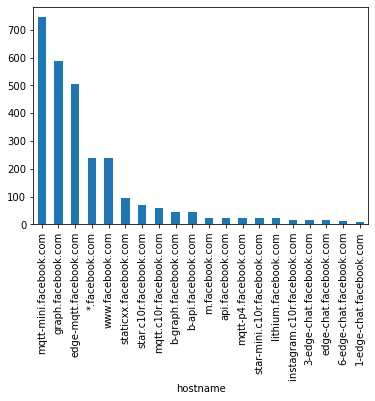

In [17]:
# Group and plot
fb_service = fb_dataf.groupby(['hostname']).size()
# fb_service
barplot = fb_service.sort_values(ascending=False).head(20).plot(kind='bar')

What happens if you match “*facebook*” instead of “*facebook.com”? Discuss the usefulness of the 
regex concept.

<ipython-input-27-903a2cb814b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fb_dataf['hostname'] = new_col


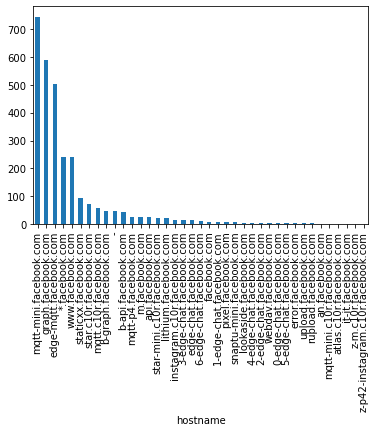

In [27]:
# Filter DataFrame for "/*facebook"
fb_string = '/*facebook*'
fb_dataf = dataf[(dataf['c_isint:38'] == 1) &
                 (
                  (dataf['http_hostname:131'].str.contains(fb_string)) |
                  (dataf['fqdn:127'].str.contains(fb_string)) |
                  (dataf['c_tls_SNI:116'].str.contains(fb_string)) |
                  (dataf['s_tls_SCN:117'].str.contains(fb_string))
                 )
                ]
# print(fb_dataf)

new_col = fb_dataf.apply(find_match, axis=1)
# new_col
fb_dataf['hostname'] = new_col
fb_dataf 
# CHIEDERE AL PROF DEL WARNING
# Group and plot
fb_service = fb_dataf.groupby(['hostname']).size()
# fb_service
barplot = fb_service.sort_values(ascending=False).head(50).plot(kind='bar')

Possibile che non ci siano differenze senza il regex? In teoria la richiesta va a fb.it che poi contatta fb.com nel caso per settare la lingua no?

What are the top-15 most used services in general (without any filter on local client or service), in terms 
of TCP connections? Plot them as a barplot, ordered by decreasing number of TCP connections.
2a) What happens if you repeat the exercise considering only HTTPS connections?

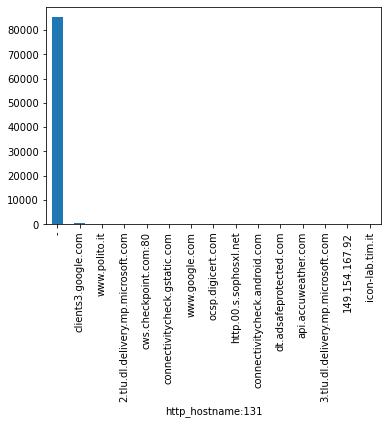

In [28]:
# 15 most used services in general
# Group and plot
dataf = dataf.groupby(['http_hostname:131']).size()
# fb_service
barplot = dataf.sort_values(ascending=False).head(15).plot(kind='bar')

What are the top-15 most used services in general (without any filter on local client or service), in terms 
of TCP connections? Plot them as a barplot, ordered by decreasing number of TCP connections.
2a) What happens if you repeat the exercise considering only HTTPS connections?
Dalla tabella nel file si legge solo che colonna 42=1 vuol dire HTTP ma non viene menzionato HTTPS

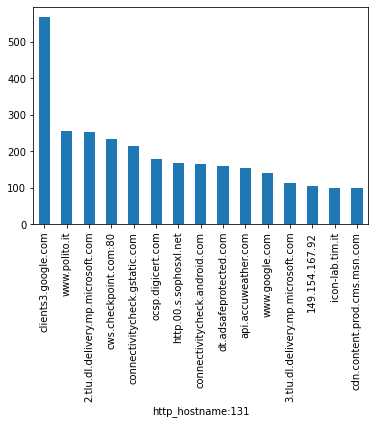

In [38]:
# 15 most used services for HTTP connections
# Group and plot
dataf_HTTP = dataf[(dataf['con_t:42']==1)].groupby(['http_hostname:131']).size()
# fb_service
barplot = dataf_HTTP.sort_values(ascending=False).head(15).plot(kind='bar')

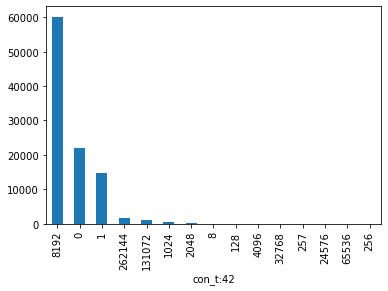

In [43]:
dataf_service = dataf.groupby(['con_t:42']).size()
# fb_service
barplot = dataf_service.sort_values(ascending=False).plot(kind='bar')

Ok ma cosa vogliono dire i numeri Mason?